# Assignment 7

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:
    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).

Additional note:

* You can complete this assignment using either your local machine or Google Colab. Your solution for this assignment should be able to run on the <span style="color:red">FREE version</span> of Google Colab. If you find that you need to upgrade to the paid version, it indicates that there is an inefficiency in your code.
---

#### ``Objectives``
1. Implement a Decision Forest for land cover classification

#### ``Motivation``

Land cover classification using machine learning (ML) techniques is important for several reasons, spanning environmental monitoring, resource management, urban planning, disaster response, and scientific research. 

#### ``Data``

In this assignment, you will use the EuroSAT dataset, consisting of Sentinel-2 RGB satellite images of 10 classes with 27000 labeled and geo-referenced samples. 

The dataset is hosted by [TensorFlow Data Collections](https://www.tensorflow.org/datasets/catalog/eurosat). To avoid any data versioning issues, we have downloaded the data for you (please see below).

`Download` link: [images + labels](https://drive.google.com/file/d/131GuYn092OlWKGopsT8arQoDreneU7SZ/view?usp=share_link). Once you unzip the file, you will see that the name of each subfolder represents the land cover classes.

---

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.preprocessing import LabelEncoder
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import pathlib
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

# FILL IN CODE HERE #
DATA_PATH = "../dataset/EuroSAT" # replace with your path

2024-06-29 21:23:17.023417: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-29 21:23:17.025273: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-29 21:23:17.066227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 21:23:17.066265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 21:23:17.067124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

^ make sure to replace DATA_PATH with the path to the directory where you saved the data.

---
### Step 1: Data ingestion

#### <span style="color:chocolate"> Exercise 1 (10 points) </span>

Let's load the 2D images and their corresponding labels. Implement the <span style="color:chocolate">load_data()</span> function below according to the following guidelines:
- to read label and image names: use the <span style="color:chocolate">os</span> library (in particular the <span style="color:chocolate">os.listdir()</span> and <span style="color:chocolate">os.path.join()</span> methods);
- to load an image: use the <span style="color:chocolate">load_image()</span> method (see list of imported libraries);
- to transform images to arrays: use the <span style="color:chocolate">img_to_array()</span> method (see list of imported libraries).

In [2]:
# land cover dictionary of {land_cover_name: land_cover_code}
land_cover = dict()

In [3]:
def load_data(path_to_data):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    
    Returns:
    images (np.ndarray): A numpy array of shape (N, 64, 64, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    ## load images and labels
    global land_cover
    images = []
    labels = []

    land_cover.clear()
    img_folder = [l for l in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, l))]
    land_cover = {name: idx for idx, name in enumerate(img_folder)}

    for land_cover_name, land_cover_id in land_cover.items():
        land_cover_path = os.path.join(DATA_PATH, land_cover_name)  # subfolder containing images

        for img_file in os.listdir(land_cover_path):
            img_path = os.path.join(land_cover_path, img_file)    # path to seatlite image
            img = load_img(img_path, target_size = (64, 64))    
            images.append(img_to_array(img))
            labels.append(land_cover_id)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [4]:
# Load images and labels. Print shapes

images, labels = load_data(DATA_PATH)
print("Shape of images ", images.shape)
print("Shape of labels ", labels.shape)

Shape of images  (27000, 64, 64, 3)
Shape of labels  (27000,)


In [5]:
land_cover

{'Residential': 0,
 'HerbaceousVegetation': 1,
 'Industrial': 2,
 'Highway': 3,
 'SeaLake': 4,
 'River': 5,
 'Forest': 6,
 'AnnualCrop': 7,
 'Pasture': 8,
 'PermanentCrop': 9}

---
### Step 2: Exploratory data analysis (EDA)

#### <span style="color:chocolate"> Exercise 2 (10 points) </span>

Plot the land cover class distribution. Are the classes balanced?

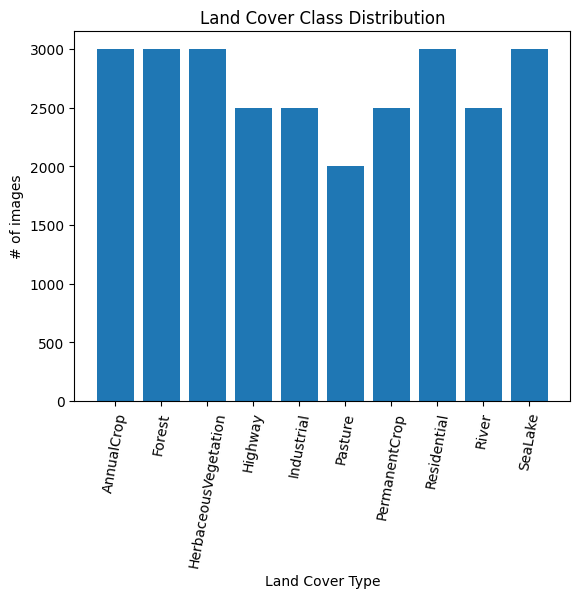

In [6]:
# FILL IN CODE HERE # 
df = pd.DataFrame(data={"label": labels})
df["label_name"] = df["label"].apply(lambda x: list(land_cover.keys())[x])

df2 = df.groupby("label_name").count()

plt.figure()
plt.bar(df2.index, df2["label"])
plt.title("Land Cover Class Distribution")
plt.xlabel("Land Cover Type")
plt.ylabel("# of images")
plt.xticks(rotation = 80)
plt.show()

Comment on class balance:  
Yes, the class is balanced with the number of images per land cover ranging from 2000 to 3000.

#### <span style="color:chocolate"> Exercise 3 (10 points) </span>

Inspect (print) one image from each class. What land classes do you think a Decision Tree classifier is more likely to confuse?

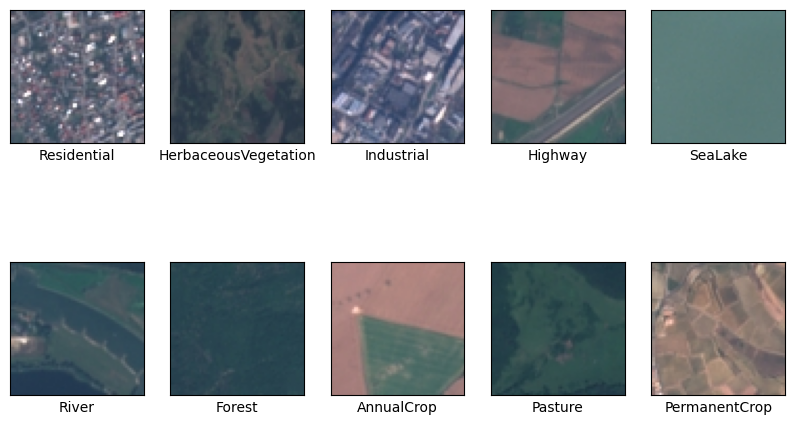

In [7]:
# FILL IN CODE HERE #
from PIL import Image

plt.figure(figsize=(10, 6))

for img_folder, idx in land_cover.items():
    img_folder_path = os.path.join(DATA_PATH, img_folder)
   
    for img_file in os.listdir(img_folder_path):
        img_file_path = os.path.join(img_folder_path, img_file)
        break    

    plt.subplot(2, 5, idx+1)
    plt.xlabel(img_folder)
    plt.xticks([])
    plt.yticks([])

    im = Image.open(img_file_path)
    plt.imshow(im)

plt.show()

Most confused land classes: SeaLake and Forest

---
### Step 3: Data preprocessing

Encode labels

In [8]:
encoder = LabelEncoder().fit(list(set(labels))) # fit on unique labels
encoded_labels = encoder.transform(labels) # apply to labels array (will get labels from 0 to 9)
encoded_labels_classes = list(encoder.classes_) # store mapping generated by the encoder

#### <span style="color:chocolate"> Exercise 4 (10 points) </span>

Create train, validation, and test data. Implement the <span style="color:chocolate">split_data()</span> function below according to the following guidelines:
- shuffle images and labels before spliting the data;
- use a 60/20/20 split.

In [9]:
def split_data(images, labels, split):
    '''Split data into train, validation and test sets.
    
    Parameters:
    images  (np.ndarray): Images of shape (N, 64, 64, 3)
    labels (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    X_train (np.ndarray): Train images of shape (N_train, 64, 64, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 64, 64, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 64, 64, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    '''
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    num_elements = labels.shape[0]

    # shuffle data
    indices = np.arange(num_elements)
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]
        
    # create data splits
    validation_from_range = int(num_elements * split[0])
    validation_to_range = int(num_elements * (1-split[2]))

    X_train = images[:validation_from_range]
    y_train = labels[:validation_from_range]

    X_val = images[validation_from_range:validation_to_range]
    y_val = labels[validation_from_range:validation_to_range]

    X_test = images[validation_to_range:]
    y_test = labels[validation_to_range:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
# define splits
split = (0.6, 0.2, 0.2)

# create train, val, test sets
X_train, y_train, X_val, y_val, X_test, y_test = split_data(images, encoded_labels, split)

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)

print('Shape of val images ', X_val.shape)
print('Shape of train labels ', y_val.shape)

print('Shape of test images ', X_test.shape)
print('Shape of test labels ', y_test.shape)

Shape of train images  (16200, 64, 64, 3)
Shape of train labels  (16200,)
Shape of val images  (5400, 64, 64, 3)
Shape of train labels  (5400,)
Shape of test images  (5400, 64, 64, 3)
Shape of test labels  (5400,)


#### <span style="color:chocolate"> Exercise 5 (10 points) </span>

Perform image transformation and augmentation. 

<span style="color:green"> Step 1: </span> Implement the <span style="color:chocolate">data_preprocessing()</span> function below according to the following guidelines:

- Applied on training set only: 
    - create additional copies of the training images by applying the following augmentation techniques to each image: adjust brightness by adding DELTA=0.3 to the pixel values, then adjust contrast to CONTRAST_FACTOR=3, then flip left right (Hint: use the methods available in the tf.image module);
    - concatenate the augmented images to the original training images. Note that the train set should be double in size after data augmentation, i.e., 32400 images and labels;
    
    
- Applied on training, validation, and test sets: normalize all pixel values by dividing by 255.0.
    
<span style="color:green"> Step 2: </span> Comment on the importance of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well).

In [11]:
def data_preprocessing(X, y, data_partition='train'):
    '''Apply transformations and augmentations to training, validation, and test dat;
    
    Parameters:
    X  (np.ndarray): Images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)   
    data_partition (str): "train"
    
    Returns:
    X (np.ndarray): Preprocessed images of shape (N, 64, 64, 3)
    y (np.ndarray): Labels of shape (N,)
    
    '''

    CONTRAST_FACTOR = 3
    DELTA = 0.3
    
    # image augmentation on training data
    if data_partition=="train":
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        y = tf.convert_to_tensor(y, dtype=tf.int32)

        # adjust brightness
        X_augm = tf.image.adjust_brightness(X, DELTA)

        # adjust contrast
        X_augm = tf.image.adjust_contrast(X_augm, contrast_factor=CONTRAST_FACTOR)

        # random flip
        X_augm = tf.image.flip_left_right(X_augm)

        # concatenate original X and augmented X_aug data
        X = tf.concat([X, X_augm], axis=0)

        # concatenate y_train (note the label is preserved)
        y_augm = y
        y = tf.concat([y, y_augm],axis=0)

        # shuffle X and y, i.e., shuffle two tensors in the same order
        shuffle = tf.random.shuffle(tf.range(tf.shape(X)[0], dtype=tf.int32))
        X = tf.gather(X, shuffle).numpy() # transform X back to numpy array instead of tensor
        y = tf.gather(y, shuffle).numpy() # transform y back to numpy array instead of tensor

    # rescale image by dividing each pixel by 255.0 
    X = X / 255.0
    
    return X, y

Comment on the importnace of adding augmented images to training data (be sure to justify why you don't augment the validation and test sets as well): [YOUR ANSWER HERE]

In [12]:
# apply data preprocessing
X_train, y_train = data_preprocessing(X_train, y_train, data_partition='train')
X_val, y_val = data_preprocessing(X_val, y_val, data_partition='val')
X_test, y_test = data_preprocessing(X_test, y_test, data_partition='val')

# print shapes
print('Shape of train images ', X_train.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val.shape)
print('Shape of test images ', X_test.shape)

Shape of train images  (32400, 64, 64, 3)
Shape of train labels  (32400,)
Shape of val images  (5400, 64, 64, 3)
Shape of test images  (5400, 64, 64, 3)


Reshape training, val, and test data (to be compatible with sklearn Decision Forests)

In [13]:
# compute number of features (multiply RGB features)
features_shape = X_train[:, :, :, 0].shape[1] * X_train.shape[2] * X_train.shape[3]
print('Total number of features used for Decision Forests', features_shape)

# reshape data
X_train_re = X_train.reshape(X_train.shape[0], features_shape)
X_val_re = X_val.reshape(X_val.shape[0], features_shape)
X_test_re = X_test.reshape(X_test.shape[0], features_shape)

# print shapes
print('Shape of train images ', X_train_re.shape)
print('Shape of train labels ', y_train.shape)
print('Shape of val images ', X_val_re.shape)
print('Shape of test images ', X_test_re.shape)

Total number of features used for Decision Forests 12288
Shape of train images  (32400, 12288)
Shape of train labels  (32400,)
Shape of val images  (5400, 12288)
Shape of test images  (5400, 12288)


---
### Step 4: Modeling

#### <span style="color:chocolate"> Exercise 6 (10 points) </span>

Implement a Decision Forest classifier according to the following guidelines (let's call this model our baseline classifier):
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> class available in the <span style="color:chocolate">sklearn.ensemble</span> module;
- Set the following argument values:
    - n_estimators=2,
    - n_jobs=1
    - random_state=7
    - max_depth=8
- Train the model on (X_train_re, y_train) data;
- Evaluate the accuracy of the model on (X_train_re, y_train) and (X_val_re, y_val) data. Comment on model performance on training vs. validation datasets. Does the model generalize well?
- Plot the confusion matrix using (y_val, y_val_pred) data. Comment on the classes that the model confuses the most.

Training Accuracy: 0.4756172839506173
Validation Accuracy: 0.46370370370370373


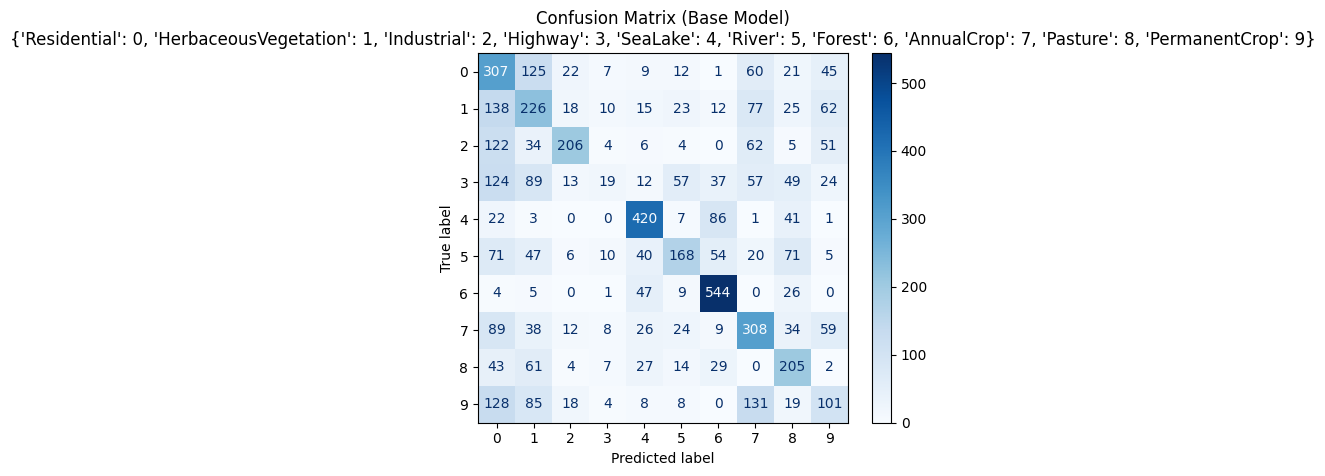

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=2,
    n_jobs=1,
    random_state=7,
    max_depth=8
)

rf_clf.fit(X_train_re, y_train)
y_train_pred = rf_clf.predict(X_train_re)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_val_pred = rf_clf.predict(X_val_re)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")

cm = confusion_matrix(y_val, y_val_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Base Model)\n{land_cover}")
plt.show()

Comment on model accuracy on training vs. validation data:  
Although both training accuracy and validation accuracy are below 0.5, they are similar to each with 0.48 and 0.46 respecitively.

Does the model generalize well?: Yes. 

Comment on the classes that the model confuses the most:  
3 (SeaLake) predits as 0 (Residential) 124 times and only predicts correctly 19 times.

#### <span style="color:chocolate"> Exercise 7 (20 points) </span>

Implement a Decision Forest classifier that improves the validation set accuracy performance of the baseline model implemented above by at least 10% (the more you can improve the better). The model should also generalize well (the performance difference between the training and validation sets should be at most 10%). Also, be sure to follow these guidelines: 
    
- Use the <span style="color:chocolate">RandomForestClassifier</span> or the <span style="color:chocolate">GradientBoostingClassifier</span> available in the <span style="color:chocolate">sklearn.ensemble</span> module
- Be explicit on how your implementation is different compared to the baseline classifier:
    - different argment values for the baseline model (RandomForestClassifier)?
    - different Decision Forest classifier?
    - different data preprocessing procedure?
    - a combination of the three points above
    - anything else?
- Train the model on (X_train_re, y_train) data.
- Evaluate the model's accuracy on (X_val_re, y_val) data. Comment on training vs. validation performance relative to baseline model.
- Does your model generalize well?
- Plot confusion matrix using the (y_val, y_val_pred) data. Comment on the classes the model confuses the most relative to the baseline.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

cv_params = {
    "n_estimators": [6, 8],     # of tress in the forest
    "max_depth": [8, 10],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [2, 4]
}


rf = RandomForestClassifier(n_jobs=-1, random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=cv_params, cv=10, n_jobs=-1, scoring="accuracy", verbose=2)
grid_search.fit(X_train_re, y_train)

best_params = grid_search.best_params_
rf_clf2 = grid_search.best_estimator_

print(f"{best_params=}")

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=6; total time=  22.8s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=6; total time=  24.4s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=8; total time=  24.8s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=8; total time=  24.9s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=6; total time=  24.9s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=8; total time=  25.3s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=8; total time=  25.7s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=6; total time=  25.7s
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=6; total time=  26.0s[CV] END max_depth=8, min_samples_leaf=2, min_samples_sp

Training Accuracy: 0.6724074074074075
Validation Accuracy: 0.5475925925925926


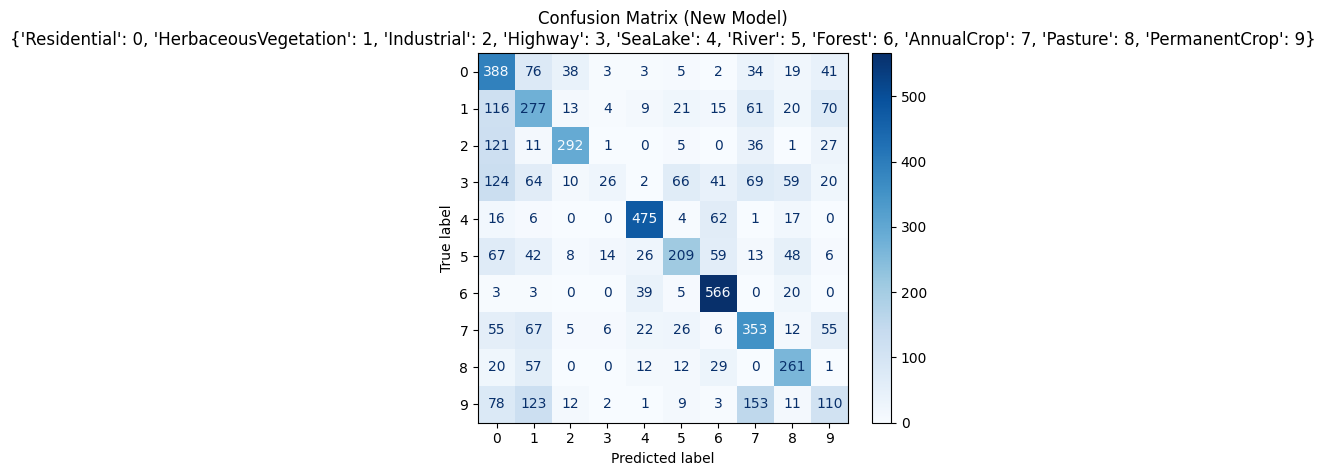

In [22]:
y_train_pred = rf_clf2.predict(X_train_re)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_val_pred = rf_clf2.predict(X_val_re)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
cm = confusion_matrix(y_val, y_val_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (New Model)\n{land_cover}")
plt.show()

How your implementation is different compared to the baseline classifier:  
To model performance, I use GridSearchCV to identify a better hyper-parameter configurations. After several trial-and-error, I found out a higher value in n_estimators and max_depth deliver a better training training accuracy. Unfortunately, it also creates much bigger accuracy gap to validation.  
To reduce the accuracy gap, I found out a higher CV folder value would reduce the chance of overfitting.

Comment on training vs. validation performance relative to baseline model:  
The new model improves accuracy by 20% (validation accuracy improves from 0.46 to 0.55)

Does the model generalize well?  
No, the accuracy gap between Training Accuracy (0.67) is significanly higher than Validation Accuracy (0.55), which indicates overfitting.

Comment on the classes the model confuses the most relative to the baseline:  
3 (SeaLake) predits as 0 (Residential) 124 times and only predicts correctly 26 times.

---
### Step 5: Evaluation and Generalization

#### <span style="color:chocolate"> Exercise 8 (2 points) </span>

Report accuracy performance on the test data using the model trained for Exercise 7. How does the test set performance compare with the one reported for the validation set?

In [23]:
y_test_pred = rf_clf2.predict(X_test_re)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.5459259259259259


Comment on test set accuracy vs. validation set accuracy:  
Test Accuracy (0.55) is in line with Validation Accuracy (0.55).

---
### Step 6: Discussion

#### <span style="color:chocolate"> Exercise 9 (8 points) </span>

Would you recommend a Decision Forest for land cover classification? Why or why not?

No. Even with extensive hyper-parameter tuning, it is still difficult to achieve reasonable accuracy. When I tried out GradientBoostingClassifier, I cannot even complete the training withint a reasonable time (>30 mins) when trying out different hyper-parameters.

#### <span style="color:chocolate"> Exercise 10 (10 points) </span>

What other ML model would you propose to improve performance over the Decision Forest classifier you implemented for Exercise 7?

Instead of GradientBoostingClassifier, I would use HistGradientBoostingClassifier for a faster training time.

---
#### <span style="color:chocolate"> Bonus question (20 points) </span>

Implement the idea proposed for Exercise 10. Perform hyperparameter tuning using the training and validation sets, then report the model performance on the test data. Does your model generalize well?

In [29]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_clf = HistGradientBoostingClassifier(
    max_iter=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

hgb_clf.fit(X_train_re, y_train)

HistGradientBoostingClassifier(max_depth=5, random_state=42)

In [30]:
y_train_pred = hgb_clf.predict(X_train_re)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_val_pred = hgb_clf.predict(X_val_re)
val_accuracy = accuracy_score(y_val, y_val_pred)

y_test_pred = hgb_clf.predict(X_test_re)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9476851851851852
Validation Accuracy: 0.7224074074074074
Test Accuracy: 0.7033333333333334


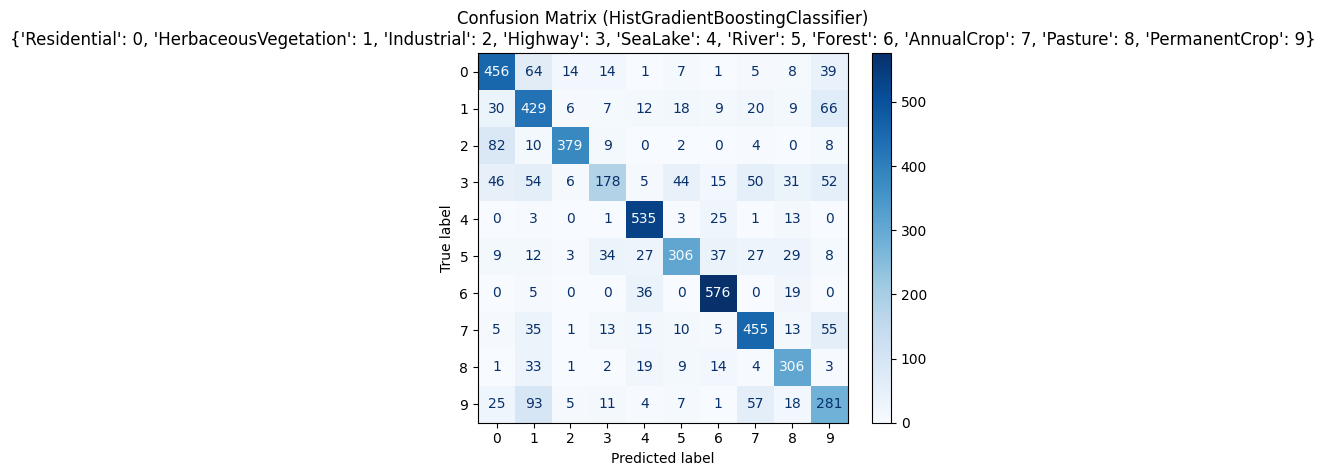

In [31]:
cm = confusion_matrix(y_val, y_val_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (HistGradientBoostingClassifier)\n{land_cover}")
plt.show()

Although the new model trained using HistGradientBoostingClassifier still does not generalize well (training accuracy of 0.95 vs validation accuracy of 0.72). However, the new model delivers a much better accuracy (>0.7) than RandomForestClasifier (~=0.55), and have shorter training time comparing to GradientBoostingClassifier.
